## Import & config

In [24]:
## utf-8 encoding
import os
import sys
from glob import glob
import requests
import random
from time import time

import numpy as np
import pandas as pd
import cv2

import timm
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

import albumentations as A
from albumentations import *
from albumentations.pytorch import ToTensorV2
from torch.autograd import Variable

import torch
import torch.nn as nn
from torch.optim import *
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from tqdm.notebook import tqdm

In [25]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw

In [26]:
### Configurations

train_folder_dir = '/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/dataset/train'
eval_folder_dir = '/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/dataset/eval'

train_imgs_dir = f'{train_folder_dir}/images'
train_labels_path = f'{train_folder_dir}/train.csv'
eval_imgs_dir = f'{eval_folder_dir}/images'
eval_labels_path = f'{eval_folder_dir}/info.csv'

cfg = {
    'model_name' : 'resnet34',
    'epochs' : 25,
    'lr' : 1e-4,
    'seed':42,
    'num_classes':18
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Processing

### dataset

In [27]:
df = pd.read_csv(train_labels_path)
df

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,006954,male,Asian,19,006954_male_Asian_19
2696,006955,male,Asian,19,006955_male_Asian_19
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20


In [28]:
## csv → label_codes, img_paths

df = pd.read_csv(train_labels_path)

def get_label(mask_tag, gender, age):
    gender = gender.lower()
    label = 0
    if mask_tag == 'Wear' and gender == 'male' and age<30: # 0:
        label = 0
    elif mask_tag == 'Wear' and gender == 'male' and 30<=age<60: # 1
        label = 1
    elif mask_tag == 'Wear' and gender == 'male' and age>=60: # 2
        label = 2
    elif mask_tag == 'Wear' and gender == 'female' and age<30: # 3
        label = 3
    elif mask_tag == 'Wear' and gender == 'female' and 30<=age<60: # 4
        label = 4
    elif mask_tag == 'Wear' and gender == 'female' and age>=60: # 5
        label = 5
    elif mask_tag == 'Incorrect' and gender == 'male' and age<30: # 6
        label = 6
    elif mask_tag == 'Incorrect' and gender == 'male' and 30<=age<60: # 7
        label = 7
    elif mask_tag == 'Incorrect' and gender == 'male' and age>=60: # 8
        label = 8
    elif mask_tag == 'Incorrect' and gender == 'female' and age<30: # 9
        label = 9
    elif mask_tag == 'Incorrect' and gender == 'female' and 30<=age<60: # 10
        label = 10
    elif mask_tag == 'Incorrect' and gender == 'female' and age>=60: # 11
        label = 11
    elif mask_tag == 'Not Wear' and gender == 'male' and age<30: # 12
        label = 12
    elif mask_tag == 'Not Wear' and gender == 'male' and 30<=age<60: # 13
        label = 13
    elif mask_tag == 'Not Wear' and gender == 'male' and age>=60: # 14
        label = 14
    elif mask_tag == 'Not Wear' and gender == 'female' and age<30: # 15
        label = 15
    elif mask_tag == 'Not Wear' and gender == 'female' and 30<=age<60: # 16
        label = 16
    elif mask_tag == 'Not Wear' and gender == 'female' and age>=60: # 17
        label = 17
    else:
        raise ValueError
    return label

label_codes = []
img_paths = []

for gender, age, folder_name in zip(df['gender'], df['age'], df['path']):
    folder_path = os.path.join(train_imgs_dir, folder_name)
    files = os.listdir(folder_path)
    for file_name in files:
        img_path = os.path.join(folder_path,file_name)
        if 'incorrect' in file_name:
            label = get_label('Incorrect', gender, age)
        elif 'mask' in file_name:
            label = get_label('Wear', gender, age)
        elif 'normal' in file_name:
            label = get_label('Not Wear', gender, age)
        else:
            raise ValueError
        img_paths.append(img_path)
        label_codes.append(label)

In [29]:
for path, code in zip(img_paths, label_codes):
    print(path, code)
    break

/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/dataset/train/images/000001_female_Asian_45/mask1.jpg 4


In [30]:
## data split
train_paths, valid_paths, train_labels, valid_labels = train_test_split(img_paths, label_codes,
                                                                        train_size = 0.7,
                                                                        shuffle = True,
                                                                        random_state = cfg['seed'],
                                                                        stratify=label_codes)

In [31]:
train_csv = pd.DataFrame(list(zip(train_paths, train_labels)), columns=['img_path', 'class'])

In [32]:
valid_csv = pd.DataFrame(list(zip(valid_paths, valid_labels)), columns=['img_path', 'class'])

In [33]:
print(len(train_csv), len(valid_csv))

13230 5670


In [34]:
train_csv

,img_path,class
0,/opt/ml/repo/level1_imageclassification_cv-lev...,0
1,/opt/ml/repo/level1_imageclassification_cv-lev...,16
2,/opt/ml/repo/level1_imageclassification_cv-lev...,4
3,/opt/ml/repo/level1_imageclassification_cv-lev...,4
4,/opt/ml/repo/level1_imageclassification_cv-lev...,4
...,...,...
13225,/opt/ml/repo/level1_imageclassification_cv-lev...,4
13226,/opt/ml/repo/level1_imageclassification_cv-lev...,4
13227,/opt/ml/repo/level1_imageclassification_cv-lev...,7
13228,/opt/ml/repo/level1_imageclassification_cv-lev...,3


### transform

In [35]:
## input csv, output img, label(class)
class MaskDataSet(Dataset): # train_labels_path
    def __init__(self, path_df, transforms=None):
        self.transforms = transforms
        self.path_df = path_df
        if transforms is None:
            print('If transforms param is None automatically Resize(224), Normalize, ToTensorV2 Apply')
    
    def __getitem__(self, index):
        img_path = self.path_df['img_path'][index]
        img = np.array(Image.open(img_path))
        img_class = self.path_df['class'][index]
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        else:
            temp_transforms = A.Compose([A.Resize(height=224, width=224), A.Normalize(), ToTensorV2()])
            img = temp_transforms(image=img)["image"]
        return img, img_class

    def __len__(self):
        return len(self.path_df)

In [36]:
train_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.HorizontalFlip(p=0.5),
                              A.RandomBrightnessContrast(p=0.5),
                              A.GaussianBlur(p=0.5),
                              A.GridDistortion(p=0.5),
                              A.Rotate(limit=30, p=0.5),
                              A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                                          std=(0.23318603,0.24300033,0.24567522)),
                              ToTensorV2()])

valid_transforms = A.Compose([A.Resize(height=224, width=224),
                              A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                                          std=(0.23318603,0.24300033,0.24567522)),
                              ToTensorV2()])

train_dataset = MaskDataSet(train_csv, train_transforms)
valid_dataset = MaskDataSet(valid_csv, valid_transforms)

In [37]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

### dataloader

In [48]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

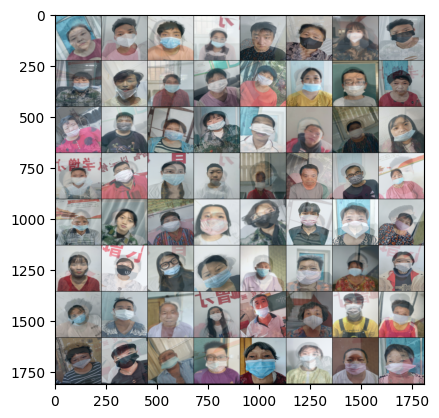

tensor(3.)


In [49]:
imgs, labels = next(iter(train_loader)) # B C H W -> B H W C
imgs, label_a, label_b, lam = mixup_data(imgs, labels)
plt.imshow(make_grid(imgs, normalize=True).permute(1,2,0))
plt.show()
# print(labels.size())
print(labels[0].float())

## Modeling

In [50]:
def get_pretrain_model(config):
    model_name = config['model_name']
    model = timm.create_model(model_name=config['model_name'], pretrained=True, num_classes=config['num_classes'])
    return model

pretrained_model = get_pretrain_model(cfg)
pretrained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [51]:
## test
batch_images, batch_labels = next(iter(train_loader))
torch.argmax(pretrained_model(batch_images.to(device)), dim=-1)

tensor([ 5,  0, 14,  2,  9, 11, 11,  5,  0, 14, 11, 14, 14,  7, 11, 11, 17, 11,
        13, 11,  9, 12, 11,  5, 13,  5,  9, 11, 11, 11,  5, 11, 11, 11,  0,  5,
         3,  5, 11,  0, 11,  3, 11, 11,  3, 14, 11,  5, 11,  0,  0, 11, 11, 14,
         3,  5,  0, 13,  0, 12, 11,  3,  0, 13], device='cuda:0')

## Training

In [52]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optim = AdamW(pretrained_model.parameters(), lr = cfg['lr'])

In [53]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [54]:
def train_and_valid(cfg, model, train_loader, valid_loader):
  result = {"train_loss" : [],
            "valid_loss" : [],
            "valid_acc":[],
            "valid_f1":[]}
            
  for epoch in tqdm((range(1,cfg['epochs']))):
      model.train()
      running_train_loss = []
      running_valid_loss = []

      preds = []
      labels = []


      for iter_idx, (train_imgs, train_labels) in enumerate(train_loader, start=1):
          train_imgs = train_imgs.to(device)
          train_labels = train_labels.to(device)
          ## make image and labels mixup
          train_imgs, train_labels_a, train_labels_b, lam = mixup_data(train_imgs, train_labels)
          inputs, targets_a, targets_b = map(Variable, (train_imgs, train_labels_a, train_labels_b))
          train_pred = model(train_imgs)
          ## get loss
          train_loss = mixup_criterion(criterion, train_pred, targets_a, targets_b, lam)
          optim.zero_grad()
          train_loss.backward()
          optim.step()
          running_train_loss.append(train_loss.cpu().item())
  
      with torch.no_grad():
        for iter_idx, (valid_imgs, valid_labels) in enumerate(valid_loader, start=1):
          model.eval()
          valid_imgs, valid_labels = valid_imgs.to(device, dtype=torch.float), valid_labels.to(device)
          
          valid_logit = model(valid_imgs)
          valid_loss = criterion(valid_logit, valid_labels)
          valid_preds = valid_logit.argmax(dim=-1)
          
          running_valid_loss.append(valid_loss.cpu().item())
          preds += valid_preds.detach().cpu().numpy().tolist()
          labels += valid_labels.detach().cpu().numpy().tolist()

      train_loss = np.mean(running_train_loss)
      valid_loss = np.mean(running_valid_loss)
      valid_f1 = f1_score(labels, preds, average='macro')
      valid_acc = accuracy_score(labels,preds)
      print(f"{epoch}/{cfg['epochs']} : train_loss:{train_loss:.4f}, \
        valid_loss:{valid_loss:.4f}, valid_acc:{valid_acc*100:.2f}, valid_f1:{valid_f1:.2f}")
      result['train_loss'].append(train_loss)
      result['valid_loss'].append(valid_loss)
      result['valid_acc'].append(valid_acc)
      result['valid_f1'].append(valid_f1)
  return result, model

## validation result

In [55]:
result, fine_tuned_model = train_and_valid(cfg, pretrained_model, train_loader, valid_loader)

1/25 : train_loss:1.4262,         valid_loss:0.4760, valid_acc:88.24, valid_f1:0.71
2/25 : train_loss:1.1709,         valid_loss:0.3833, valid_acc:91.68, valid_f1:0.82
3/25 : train_loss:1.0993,         valid_loss:0.3358, valid_acc:93.19, valid_f1:0.84
4/25 : train_loss:1.0151,         valid_loss:0.2904, valid_acc:94.14, valid_f1:0.85
5/25 : train_loss:1.0150,         valid_loss:0.3111, valid_acc:93.54, valid_f1:0.83
6/25 : train_loss:0.9494,         valid_loss:0.3142, valid_acc:94.81, valid_f1:0.89
7/25 : train_loss:0.9374,         valid_loss:0.2197, valid_acc:95.40, valid_f1:0.92
8/25 : train_loss:0.9095,         valid_loss:0.2331, valid_acc:96.53, valid_f1:0.94
9/25 : train_loss:0.9060,         valid_loss:0.2521, valid_acc:96.56, valid_f1:0.93
10/25 : train_loss:0.8901,         valid_loss:0.2679, valid_acc:96.95, valid_f1:0.93
11/25 : train_loss:0.8464,         valid_loss:0.1841, valid_acc:97.62, valid_f1:0.96
12/25 : train_loss:0.8439,         valid_loss:0.2158, valid_acc:97.57, val

## checkpoints

In [56]:
fine_tuned_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [57]:
result

{'train_loss': [1.4262052212936291,
  1.1708518936150316,
  1.0993286867936451,
  1.0151093155865507,
  1.0150327799112902,
  0.9494055507407673,
  0.9373943574618602,
  0.90946362891059,
  0.9059718841515877,
  0.8901484116983874,
  0.8463518974789674,
  0.843922987004409,
  0.8469324635278775,
  0.8034300187575645,
  0.801408581075749,
  0.8273472029733773,
  0.8183818174805042,
  0.7958107936209526,
  0.791274974203628,
  0.7684614290505791,
  0.754236196136273,
  0.7655082796362863,
  0.8042202507672103,
  0.7246858977897156],
 'valid_loss': [0.47600391205776943,
  0.3833078869273154,
  0.3358166755250331,
  0.29036173492335204,
  0.31108845301558463,
  0.3142205048143194,
  0.21968282976847017,
  0.2330552413222495,
  0.25208489479643575,
  0.26786150456814284,
  0.18407338112592697,
  0.21578749930590727,
  0.2141033091237036,
  0.15535092471020945,
  0.20937623753306572,
  0.25749527236049097,
  0.2099548965022805,
  0.16197674579164956,
  0.181674177559574,
  0.1603389887997273

In [58]:
save_file = {'model' : fine_tuned_model.state_dict(),
             'result': result,
             'config': cfg}

In [59]:
save_keyword = cfg['model_name']+'_mixup'
save_path = f'/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/checkpoints/3_{save_keyword}.pt'

In [60]:
torch.save(save_file, save_path)

## Inference

In [61]:
eval_imgs_dir = f'{eval_folder_dir}/images'
os.listdir(eval_imgs_dir)

['f3152b9e149732cc7913ad2864bfdba2b820741f.jpg',
 'ccb42a6a1b203887c15edcf7875bd46a678215fc.jpg',
 '935011ab64c0df94353ea6526cad456bdad13cbe.jpg',
 '115d6c044d7206e0a5603f80b342e82e23f3af5f.jpg',
 'f8721a9705ac5f30f9feaf8970cf89674682b8f3.jpg',
 '1938e71f0cb92db5f66c8eeddfef174276ecca2e.jpg',
 '75efc145b8d946b8b6d2a3fab8df8b2f99f94480.jpg',
 'c0fb034bf2b104da56e026d782f3cbff81db1fba.jpg',
 '3a63d338f6b0ffaf2274be9e1844e813e56565c8.jpg',
 'eebe69a972bd1c45181c323b09a074b4e4c9a5e6.jpg',
 '638c3d6b33521052dbd4f16c8e3b25e6d3e4e48d.jpg',
 '60ea7f9a1a01c4089312fc5b2d3255716b0916a0.jpg',
 'f3483594612acb9f02b869b5de6ce8c82a33c205.jpg',
 '754a642ddef7e28bef6f46043348f50ad7b58042.jpg',
 '56036c87a28920b83b4c97a2a48eb12bb3a354b1.jpg',
 'be455126a477f93da9464ddb792ddf343b05123c.jpg',
 '83e383648f08d6e4cc7cf6fff7d9f7b38b800488.jpg',
 '89b723e1c73beee3494ccb2b20fcbdaa7598d464.jpg',
 'ca16a2e22e55d2a0d53370017d44dae93db21f12.jpg',
 'f3d1f43e67bc2a643254b1fe58350077ab2d9e37.jpg',
 'dedd0fe67a8ba05e2d

In [62]:
eval_labels_path = f'{eval_folder_dir}/info.csv'
eval_csv = pd.read_csv(eval_labels_path)

In [63]:
img_path = []
for file_name in eval_csv['ImageID']:
    file_path = os.path.join(eval_imgs_dir, file_name)
    img_path.append(file_path)
    # print(file_path)

In [64]:
test_csv = pd.DataFrame(img_path)
test_csv.columns = ['img_path']
test_csv

,img_path
0,/opt/ml/repo/level1_imageclassification_cv-lev...
1,/opt/ml/repo/level1_imageclassification_cv-lev...
2,/opt/ml/repo/level1_imageclassification_cv-lev...
3,/opt/ml/repo/level1_imageclassification_cv-lev...
4,/opt/ml/repo/level1_imageclassification_cv-lev...
...,...
12595,/opt/ml/repo/level1_imageclassification_cv-lev...
12596,/opt/ml/repo/level1_imageclassification_cv-lev...
12597,/opt/ml/repo/level1_imageclassification_cv-lev...
12598,/opt/ml/repo/level1_imageclassification_cv-lev...


In [65]:
class TestMaskDataSet(Dataset):#train_labels_path
    def __init__(self, path_df, transforms=None):
        self.transforms = transforms
        self.path_df = path_df
        if transforms is None: # transform이 없으면 자동으로 3개의 transform이 적용됨.
            print('If transforms param is None automatically Resize(224), Normalize, ToTensorV2 Apply')
    
    def __getitem__(self, index):
        img_path = self.path_df['img_path'][index]
        img = np.array(Image.open(img_path))
        # img_class = self.path_df['class'][index]
        if self.transforms is not None:
            img = self.transforms(image=img)["image"]
        else:
            temp_transforms = A.Compose([A.Resize(height=224, width=224), A.Normalize(), ToTensorV2()])
            img = temp_transforms(image=img)["image"]
        return img # , img_class

    def __len__(self):
        return len(self.path_df)

In [66]:
test_transforms = A.Compose([A.Resize(height=224, width=224),
                             A.Normalize(mean=(0.56019358,0.52410121,0.501457),
                                         std=(0.23318603,0.24300033,0.24567522)),
                             ToTensorV2()])

In [67]:
test_dataset = TestMaskDataSet(test_csv, transforms = test_transforms)

In [68]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [69]:
def inference(model, test_loader):
    total_test_preds = []
    with torch.no_grad():
        for iter_idx, test_imgs in enumerate(test_loader, start=1):
            model.eval()
            test_imgs = test_imgs.to(device, dtype=torch.float)
            test_logit = model(test_imgs)
            test_preds = test_logit.argmax(dim=-1)
            total_test_preds += test_preds.detach().cpu().numpy().tolist()
    return total_test_preds

In [70]:
test_prediction_list = inference(fine_tuned_model, test_loader)

In [71]:
len(test_prediction_list)

12600

In [72]:
df_submission = pd.read_csv('/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/dataset/eval/submission.csv')
df_submission['ans']=test_prediction_list

In [73]:
(test_prediction_list == df_submission['ans']).sum()

12600

In [74]:
df_submission

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,12
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,4


In [75]:
save_path

'/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/checkpoints/3_resnet34_mixup.pt'

In [78]:
submission_file_path = '/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/submission/'
save_path = submission_file_path+f'{save_keyword}.csv'
df_submission.to_csv(save_path)